# TIME SERIES FORECASTING- STOCK PRICE

So let's pick a SENSEX stock and forecast with ARIMA Model.

In [1]:
# Imports of relevant packages
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [2]:
# These historical prices are downloded from Yahoo Finance
df = pd.read_csv('RELIANCE.BO (2).csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-01,442.750000,446.075012,442.100006,444.024994,415.421387,362864.0
1,2015-01-02,444.399994,448.000000,442.000000,442.799988,414.275238,521670.0
2,2015-01-05,442.774994,445.450012,437.649994,438.549988,410.299072,657576.0
3,2015-01-06,436.000000,436.000000,416.049988,418.049988,391.119659,1944344.0
4,2015-01-07,419.350006,429.399994,418.600006,427.700012,400.148010,1320684.0


In [4]:
# Convert date to datetime format and save it as index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
trend = df[['Close']]

Text(0.5, 1.0, 'Closing Stock Prices')

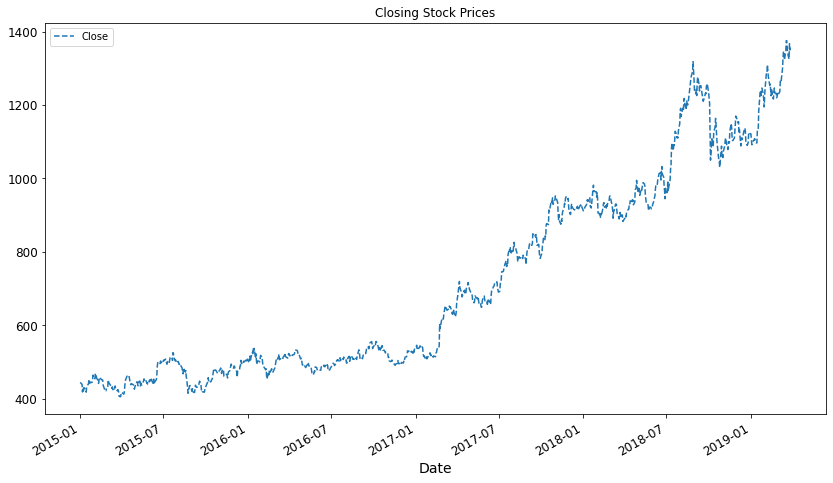

In [5]:
# Let's plot the series
trend.plot(style = '--' , kind = 'line', figsize = (14,8), label = 'Closing Price')
plt.title('Closing Stock Prices')

In [6]:
# Resample series to a daily frequency, remove missing values and fix date range
trend = trend.resample('D').fillna(method ='ffill')
trend = trend.fillna(method = 'ffill')
trend = trend.loc[pd.date_range(start = '2015-01-01', end = '2018-12-31')]

### Converting into a stationary series

A Series with a predictable internal structure, with constant mean and variance is called stationary time series. Stationary series is important for modelling to get stable parameter. The parameters of stationary series does not fluctuate with time
The requirement for this conversion can be checked with the Adfuller test. If the p- value  of the test is below 5%, we can reject the null hypothesis that the series is a random walk.

In [7]:
# Adfuller test on actual series
from statsmodels.tsa.stattools import adfuller

result = adfuller(trend)
print("The p-value for the ADF test is ", result[1]) 

The p-value for the ADF test is  0.9420178408799313


In [8]:
# Adfuller test on 1st order differenced series
result = adfuller(trend.diff().dropna())
print("The p-value for the ADF test is ", result[1]) 

The p-value for the ADF test is  4.193370735201671e-12


Since the p-value is statistically significant, we can reject the null hypothesis that the series is a random walk.

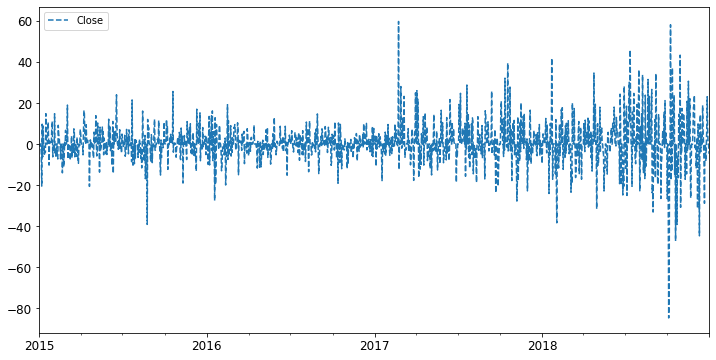

In [9]:
# Let's plot the stationary series
trend.diff().plot(style = '--' , kind = 'line', figsize = (12,6))

### AUTO CORRELATION FUNCTION

What is Autocorrelation? Correlation of a time series with a lagged copy of itself.

Autocorreletion function not only shows autocorreletion for lag 1 but also all different lags. 

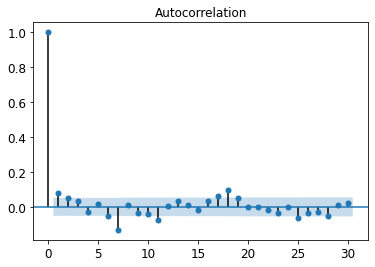

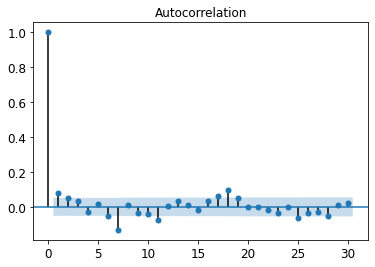

In [10]:
# Autocorrelation function of 1st order differenced series

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(trend.diff().dropna(), lags = 30)

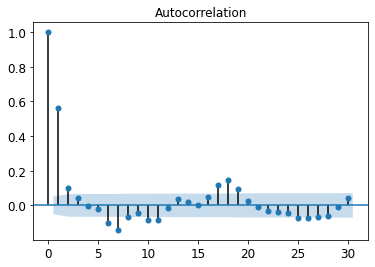

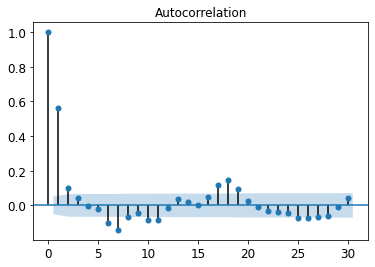

In [11]:
# AUTO CORRELATION FUNCTION OF 2nd order differenced series

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(trend.diff(2).dropna(), lags = 30)

If we look at the ACF of the 1st order differenced series, the last value in the series can be used for forecasting though it is not very significant. If we look at the ACF of the 2nd order differenced series, the last 2 values in the series can be used for forecasting, as the 1st 2 lags are signficant. 



### Selecting the AR term

PARTIAL  AUTO CORRELATION FUNCTION- PACF measures incremental benefit of adding another lag. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

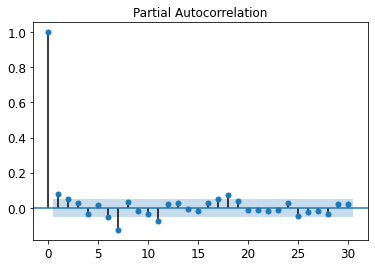

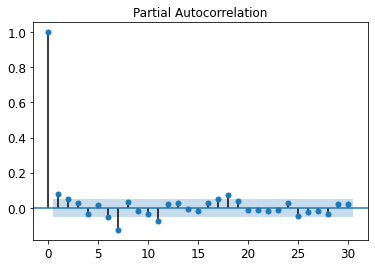

In [17]:
# PACF of the 1st order differenced series
plot_pacf(trend.diff().dropna(), lags = 30)

As one observes the PACF of 1st order differenced series, lag 1 is significant, though not very high.

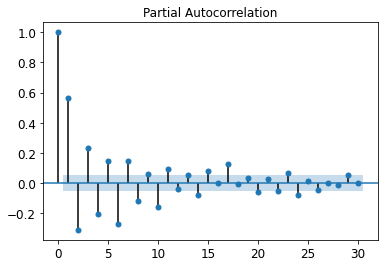

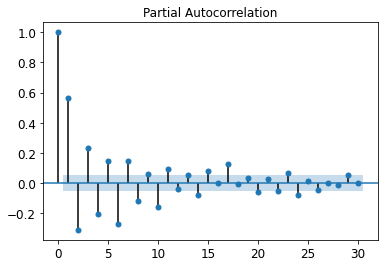

In [18]:
# PACF of 2nd order differenced series
plot_pacf(trend.diff(2).dropna(), lags = 30)

In the PACF of 2nd ordered difference series, one can see many significant lags, however the 1st 3 appear to be significant and beyond that there is fluctuation in the significance levels. 

Another tool to identify the order of a model is to look at the Bayesian Information Criterion (BIC). We can compute the BIC at various orders of p, in an ARMA(p,0) and then pick the value of p where it is least. 

Text(0, 0.5, 'BIC')

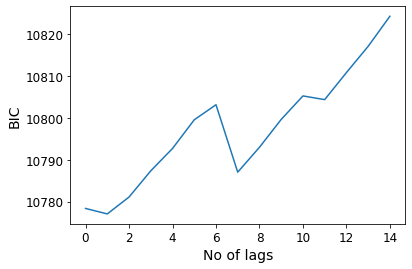

In [21]:
# BIC for 1st order differenced series
from statsmodels.tsa.arima_model import ARMA
bic = []
for p in range(15):
    res = ARMA(trend.diff(1).dropna(), freq='D',order = (p,0)).fit()
    bic.append(res.bic)
plt.plot(range(15), bic)
plt.xlabel('No of lags')
plt.ylabel('BIC')

The BIC is lowest for p=1. We can select AR as 1

Text(0, 0.5, 'BIC')

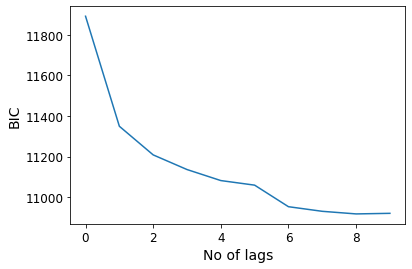

In [22]:
# BIC for 2nd order differenced series
bic = []
for p in range(10):
    res = ARMA(trend.diff(2).dropna(), freq = 'D',order = (p,0)).fit()
    bic.append(res.bic)
plt.plot(range(10), bic)
plt.xlabel('No of lags')
plt.ylabel('BIC')

Looking at this, its difficult to decide since adding too many AR terms may not be statistically significant. So we can stick with AR=3 as per the PACF.

### Selecting MA TERM

Just like how we looked at the PACF plot for the number of AR terms, you can look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.

The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

Looking at ACF of 1st order differenced series MA is 1 and for the 2nd order differenced series, it is 2.

Lets check the model summary for ARIMA(1,1,1)

In [12]:

from statsmodels.tsa.arima_model import ARIMA
model1 = ARIMA(trend, order = (1,1,1))
model1_fit = model1.fit()
print(model1_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1460
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5376.124
Method:                       css-mle   S.D. of innovations              9.615
Date:                Tue, 17 Nov 2020   AIC                          10760.248
Time:                        15:32:07   BIC                          10781.393
Sample:                    01-02-2015   HQIC                         10768.136
                         - 12-31-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.4630      0.289      1.604      0.109      -0.103       1.029
ar.L1.D.Close     0.4647      0.158      2.938      0.003       0.155       0.775
ma.L1.D.Close    -0.3859      0.164     

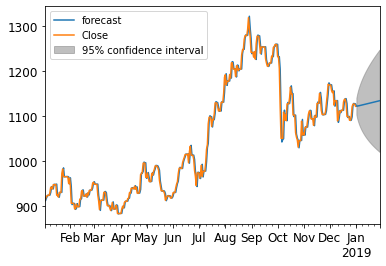

In [13]:
# Let's view the plot prediction and forecast for a month
model1_fit.plot_predict(start = '2018-01-02', end = '2019-01-28')
plt.show()

In [14]:
# Extract the forecast values and confidence intervals
pred2 = model1_fit.forecast(steps = 31, alpha = 0.05)
forecast, stderr, conf=pred2
forecast_df = pd.DataFrame(forecast, index = pd.date_range(start = '2019-01-01', end = '2019-01-31'))
conf_df = pd.DataFrame(conf, index = pd.date_range(start = '2019-01-01', end = '2019-01-31'))

In [15]:
# Sample from the actual series for 1 year duration
df = df.resample('D').fillna(method ='ffill')
actual = df.loc[pd.date_range(start = '2018-01-02', end = '2019-01-31')]['Close']

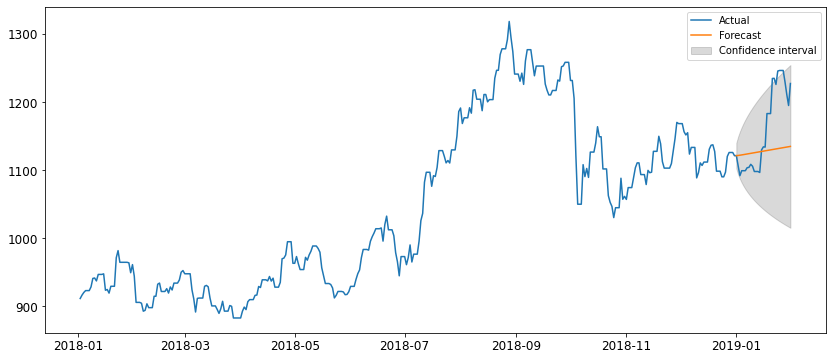

In [16]:
# Let's get a clear view for the forecat period
plt.figure(figsize = (14,6))
plt.plot(actual, label = 'Actual')
plt.plot(forecast_df, label = 'Forecast')
plt.fill_between(conf_df.index, conf_df[0], conf_df[1], 
                 color = 'k', alpha = .15, label = 'Confidence interval')
plt.legend()

And the actual observed values almost lie within the 95% confidence band. At very extreme high values few instances are beyond this interval.

But each of the predicted forecasts is consistently below the actuals. This might be slightly improved with the ARIMA(3,2,1) model.

In [17]:
model = ARIMA(trend, order = (3, 2, 2))  
res2 = model.fit() 
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.Close   No. Observations:                 1459
Model:                 ARIMA(3, 2, 2)   Log Likelihood               -5374.790
Method:                       css-mle   S.D. of innovations              9.608
Date:                Tue, 17 Nov 2020   AIC                          10763.580
Time:                        15:32:12   BIC                          10800.578
Sample:                    01-03-2015   HQIC                         10777.382
                         - 12-31-2018                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0005      0.001      0.775      0.438      -0.001       0.002
ar.L1.D2.Close    -0.3846      0.238     -1.619      0.106      -0.850       0.081
ar.L2.D2.Close     0.0783      0.033      2.368      0.018       0.013       0.143
ar.L3.D2.Close     0.0576      0.027      2.142      0.032       0.005       0.110
ma.L1.D2.Close    -0.5431      0.237     -2.294      0.022      -1.007      -0.079
ma.L2.D2.Close    -0.4569      0.237     -1.930      0.054      -0.921       0.007
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.9345           -0.0000j            2.9345           -0.0000
AR.2           -2.1472           -1.1445j            2.4331           -0.4221
AR.3           -2.1472           +1.1445j            2.4331            0.4221
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -2.1887           +0.0000j            2.1887            0.5000
-----------------------------------------------------------------------------
"""

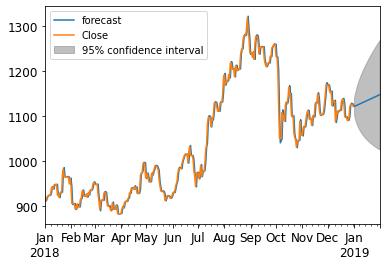

In [18]:
res2.plot_predict(start = '2018-01-01', end = '2019-01-31')
plt.show()

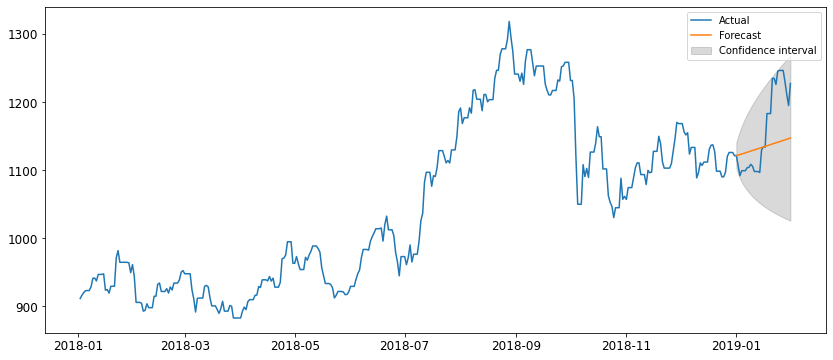

In [19]:
pred2 = res2.forecast(steps = 31, alpha = 0.05)
forecast, stderr, conf = pred2
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start = '2019-01-01', end = '2019-01-31'))
conf_df = pd.DataFrame(conf, index=pd.date_range(start = '2019-01-01', end = '2019-01-31'))
plt.figure(figsize = (14,6))
plt.plot(actual, label = 'Actual')
plt.plot(forecast_df, label = 'Forecast')
plt.fill_between(conf_df.index, conf_df[0], conf_df[1], 
                 color = 'k', alpha = .15, label = 'Confidence interval')
plt.legend()

In [20]:
### Mean absolute error and Correlation between true and predicted series.

In [21]:
from sklearn.metrics import mean_absolute_error as mae
actual = actual.loc[pd.date_range(start = '2019-01-01', end = '2019-01-31')]
mae(actual, forecast_df)

47.120756569945385

In [22]:
np.corrcoef(actual, forecast_df[0])[0][1]

0.8815865529279406

In [23]:
# forecasting for 2 steps

In [24]:
trend = trend.loc[pd.date_range(start='2015-01-01', end='2018-12-11')]

In [28]:
model = ARIMA(trend, order=(3, 2, 2))  
res2 = model.fit() 


In [30]:
pred2 = res2.forecast(steps = 3, alpha = 0.05)
forecast, stderr, conf=pred2
forecast_df = pd.DataFrame(forecast, index = pd.date_range(start = '2018-12-12', end = '2018-12-14'))
from sklearn.metrics import mean_absolute_error as mae

actual = df.loc[pd.date_range(start = '2018-12-12', end = '2018-12-14')]['Close']
mae(actual, forecast_df)

#np.corrcoef(actual, forecast_df[0])[0][1]

14.330421660597645

In [31]:
np.corrcoef(actual, forecast_df[0])[0][1]

0.9144290372138256

As seen, the forecast is more accurate for shorter duration due to the construct of the model.

Reference and resources:
    1. https://www.datacamp.com/tracks/time-series-with-python
    2. https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
    
